<a href="https://colab.research.google.com/github/Untick/IrisID_gr2/blob/Alexey-Tatarinov-folder/Iris_Model_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Импорт библиотек и модулей**

In [1]:
import gdown

import os

! pip install autokeras
import autokeras as ak

! pip install Augmentor
import Augmentor

import zipfile

import numpy as np

import tensorflow as tf

from tensorflow.keras.models import Sequential, load_model

from tensorflow.keras.layers import (Dense, Conv2D, MaxPooling2D, Flatten, 
                                     Dropout, BatchNormalization, Rescaling,
                                     GlobalAveragePooling2D, RandomFlip, Input,
                                     RandomRotation, RandomZoom, RandomContrast)

from tensorflow.keras.applications import VGG19, ResNet50, Xception

# from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input

from tensorflow.keras.utils import to_categorical

from tensorflow.keras.preprocessing.image import (ImageDataGenerator, 
                                                 DirectoryIterator)

from tensorflow.keras.optimizers import Adam

from tensorflow.keras.callbacks import ModelCheckpoint

from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from sklearn.preprocessing import LabelEncoder

from sklearn.preprocessing import OneHotEncoder

from PIL import Image, ImageEnhance

import matplotlib.pyplot as plt

%matplotlib inline

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 148.6/148.6 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.1/176.1 kB 21.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.7/527.7 kB 46.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 87.1 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# **Подготовка датасета**

## **Задание гиперпараметров**

In [2]:
PATH          = '/content/drive/MyDrive/iris_ds'
PATH_AUG      = '/content/drive/MyDrive/Iris'
TRAIN_VAL_PATH_AUG = '/content/drive/MyDrive/Iris_train_val_aug'
TRAIN_VAL_PATH = '/content/drive/MyDrive/iris_ds_train_val'
TEST_PATH = '/content/drive/MyDrive/iris_ds_test'

VAL_SPLIT           = 0.2

IMG_WIDTH_1         = 160
IMG_HEIGHT_1        = 120
IMG_WIDTH_2         = 80
IMG_HEIGHT_2        = 60
IMG_CHANNELS        = 3

ROTATION_RANGE      = 10
WIDTH_SHIFT_RANGE   = 0.1
HEIGHT_SHIFT_RANGE  = 0.1
ZOOM_RANGE          = 0.1
BRIGHTNESS_RANGE    = (0.5, 1.3)
HORIZONTAL_FLIP     = False

EPOCHS              = 20
BATCH_SIZE          = 24
OPTIMIZER_LEGACY    = tf.keras.optimizers.legacy.Adam(0.0001)
OPTIMIZER           = tf.keras.optimizers.Adam(0.0001)

## **Загрузка датасета**

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import shutil

# Создание целевых папок, если они не существуют
os.makedirs(TEST_PATH, exist_ok=True)
os.makedirs(TRAIN_VAL_PATH, exist_ok=True)

# Получение списка подпапок в папке PATH
subfolders = [f for f in os.listdir(PATH) if os.path.isdir(os.path.join(PATH, f))]

# Обработка каждой подпапки
for subfolder in subfolders:
    # Путь к исходной папке клиента
    client_folder = os.path.join(PATH, subfolder)
    
    # Путь к папке клиента в '/content/drive/MyDrive/iris_ds_test'
    target_client_folder_1 = os.path.join(TEST_PATH, subfolder)
    os.makedirs(target_client_folder_1, exist_ok=True)
    
    # Путь к папке клиента в '/content/drive/MyDrive/iris_ds_train_val'
    target_client_folder_2 = os.path.join(TRAIN_VAL_PATH, subfolder)
    os.makedirs(target_client_folder_2, exist_ok=True)
    
    # Получение списка файлов в папке клиента
    files = os.listdir(client_folder)
    
    # Копирование первого файла в '/content/drive/MyDrive/iris_ds_test'
    first_file = files[0]
    source_path = os.path.join(client_folder, first_file)
    target_path = os.path.join(target_client_folder_1, first_file)
    shutil.copyfile(source_path, target_path)
    
    # Копирование оставшихся пяти файлов в '/content/drive/MyDrive/iris_ds_train_val'
    remaining_files = files[1:]
    for file in remaining_files:
        source_path = os.path.join(client_folder, file)
        target_path = os.path.join(target_client_folder_2, file)
        shutil.copyfile(source_path, target_path)


## **Аугментация**

In [4]:
for folder in os.listdir(TRAIN_VAL_PATH):
    if os.path.isdir(os.path.join(TRAIN_VAL_PATH, folder)):
        # Создаем генератор аугментации для каждой папки
        p = Augmentor.Pipeline(os.path.join(TRAIN_VAL_PATH, folder), output_directory=os.path.join(f'/content/drive/MyDrive/Iris_train_val_aug/{folder}'))
        # Добавляем операции аугментации
        # Вращение изображения
        p.rotate(probability=0.2, max_left_rotation=10, max_right_rotation=10)
        # увеличение
        #p.zoom(probability=0.2, min_factor=1.1, max_factor=1.2)
        # Обрезание изображения
        p.crop_random(probability=0.1, percentage_area=0.95)
        # Изменение яркости
        p.random_brightness(probability=0.5, min_factor=0.7, max_factor=1.3)
        # Изменение контрасности
        p.random_contrast(probability=0.5, min_factor=0.7, max_factor=1.3)
        # Применяем аугментацию
        p.sample(50)
print('Аугментация завершена')

Initialised with 5 image(s) found.
Output directory set to /content/drive/MyDrive/Iris_train_val_aug/client_12.

Processing <PIL.Image.Image image mode=RGB size=768x576 at 0x7F28A8A93A30>: 100%|██████████| 50/50 [00:08<00:00,  5.88 Samples/s]


Initialised with 5 image(s) found.
Output directory set to /content/drive/MyDrive/Iris_train_val_aug/client_15.

Processing <PIL.Image.Image image mode=RGB size=768x576 at 0x7F28B39DB880>: 100%|██████████| 50/50 [00:06<00:00,  7.48 Samples/s]


Initialised with 5 image(s) found.
Output directory set to /content/drive/MyDrive/Iris_train_val_aug/client_23.

Processing <PIL.Image.Image image mode=RGB size=768x576 at 0x7F28A8A92440>: 100%|██████████| 50/50 [00:08<00:00,  6.13 Samples/s]


Initialised with 5 image(s) found.
Output directory set to /content/drive/MyDrive/Iris_train_val_aug/client_13.

Processing <PIL.Image.Image image mode=RGB size=768x576 at 0x7F294267AD70>: 100%|██████████| 50/50 [00:09<00:00,  5.36 Samples/s]


Initialised with 5 image(s) found.
Output directory set to /content/drive/MyDrive/Iris_train_val_aug/client_40.

Processing <PIL.Image.Image image mode=RGB size=768x576 at 0x7F28A8AA71F0>: 100%|██████████| 50/50 [00:09<00:00,  5.51 Samples/s]


Initialised with 5 image(s) found.
Output directory set to /content/drive/MyDrive/Iris_train_val_aug/client_49.

Processing <PIL.Image.Image image mode=RGB size=768x576 at 0x7F28A8A93B20>: 100%|██████████| 50/50 [00:06<00:00,  7.16 Samples/s]


Initialised with 5 image(s) found.
Output directory set to /content/drive/MyDrive/Iris_train_val_aug/client_25.

Processing <PIL.Image.Image image mode=RGB size=768x576 at 0x7F28A8A91DB0>: 100%|██████████| 50/50 [00:07<00:00,  6.91 Samples/s]


Initialised with 5 image(s) found.
Output directory set to /content/drive/MyDrive/Iris_train_val_aug/client_22.

Processing <PIL.Image.Image image mode=RGB size=768x576 at 0x7F28A8AA6470>: 100%|██████████| 50/50 [00:09<00:00,  5.54 Samples/s]


Initialised with 5 image(s) found.
Output directory set to /content/drive/MyDrive/Iris_train_val_aug/client_47.

Processing <PIL.Image.Image image mode=RGB size=768x576 at 0x7F28A8A93F70>: 100%|██████████| 50/50 [00:07<00:00,  6.86 Samples/s]


Initialised with 5 image(s) found.
Output directory set to /content/drive/MyDrive/Iris_train_val_aug/client_14.

Processing <PIL.Image.Image image mode=RGB size=768x576 at 0x7F28B3993970>: 100%|██████████| 50/50 [00:07<00:00,  6.62 Samples/s]


Initialised with 5 image(s) found.
Output directory set to /content/drive/MyDrive/Iris_train_val_aug/client_48.

Processing <PIL.Image.Image image mode=RGB size=729x547 at 0x7F28A8AE30D0>: 100%|██████████| 50/50 [00:08<00:00,  5.94 Samples/s]


Initialised with 5 image(s) found.
Output directory set to /content/drive/MyDrive/Iris_train_val_aug/client_64.

Processing <PIL.Image.Image image mode=RGB size=768x576 at 0x7F28A8AE2830>: 100%|██████████| 50/50 [00:09<00:00,  5.19 Samples/s]


Initialised with 5 image(s) found.
Output directory set to /content/drive/MyDrive/Iris_train_val_aug/client_8.

Processing <PIL.Image.Image image mode=RGB size=768x576 at 0x7F28A8A91CF0>: 100%|██████████| 50/50 [00:08<00:00,  5.89 Samples/s]


Initialised with 5 image(s) found.
Output directory set to /content/drive/MyDrive/Iris_train_val_aug/client_6.

Processing <PIL.PngImagePlugin.PngImageFile image mode=RGB size=768x576 at 0x7F28A8AE3C70>: 100%|██████████| 50/50 [00:06<00:00,  7.37 Samples/s]


Initialised with 5 image(s) found.
Output directory set to /content/drive/MyDrive/Iris_train_val_aug/client_7.

Processing <PIL.Image.Image image mode=RGB size=729x547 at 0x7F28A8A92D10>: 100%|██████████| 50/50 [00:08<00:00,  5.98 Samples/s]


Initialised with 5 image(s) found.
Output directory set to /content/drive/MyDrive/Iris_train_val_aug/client_9.

Processing <PIL.PngImagePlugin.PngImageFile image mode=RGB size=768x576 at 0x7F28A8AE3BE0>: 100%|██████████| 50/50 [00:08<00:00,  5.68 Samples/s]


Initialised with 5 image(s) found.
Output directory set to /content/drive/MyDrive/Iris_train_val_aug/client_46.

Processing <PIL.Image.Image image mode=RGB size=768x576 at 0x7F28A8AE2FE0>: 100%|██████████| 50/50 [00:07<00:00,  6.44 Samples/s]


Initialised with 5 image(s) found.
Output directory set to /content/drive/MyDrive/Iris_train_val_aug/client_1.

Processing <PIL.Image.Image image mode=RGB size=768x576 at 0x7F28A8AFBAF0>: 100%|██████████| 50/50 [00:07<00:00,  6.77 Samples/s]


Initialised with 5 image(s) found.
Output directory set to /content/drive/MyDrive/Iris_train_val_aug/client_24.

Processing <PIL.Image.Image image mode=RGB size=768x576 at 0x7F28A8AE3BE0>: 100%|██████████| 50/50 [00:07<00:00,  6.73 Samples/s]


Initialised with 5 image(s) found.
Output directory set to /content/drive/MyDrive/Iris_train_val_aug/client_41.

Processing <PIL.Image.Image image mode=RGB size=768x576 at 0x7F28A8AF9450>: 100%|██████████| 50/50 [00:09<00:00,  5.27 Samples/s]


Initialised with 5 image(s) found.
Output directory set to /content/drive/MyDrive/Iris_train_val_aug/client_30.

Processing <PIL.Image.Image image mode=RGB size=768x576 at 0x7F28A8AFBD30>: 100%|██████████| 50/50 [00:09<00:00,  5.34 Samples/s]


Initialised with 5 image(s) found.
Output directory set to /content/drive/MyDrive/Iris_train_val_aug/client_37.

Processing <PIL.Image.Image image mode=RGB size=768x576 at 0x7F28A8AA7A60>: 100%|██████████| 50/50 [00:09<00:00,  5.48 Samples/s]


Initialised with 5 image(s) found.
Output directory set to /content/drive/MyDrive/Iris_train_val_aug/client_63.

Processing <PIL.Image.Image image mode=RGB size=768x576 at 0x7F28B39DB550>: 100%|██████████| 50/50 [00:06<00:00,  7.43 Samples/s]


Initialised with 5 image(s) found.
Output directory set to /content/drive/MyDrive/Iris_train_val_aug/client_55.

Processing <PIL.Image.Image image mode=RGB size=768x576 at 0x7F28A8B08A90>: 100%|██████████| 50/50 [00:08<00:00,  6.19 Samples/s]


Initialised with 5 image(s) found.
Output directory set to /content/drive/MyDrive/Iris_train_val_aug/client_39.

Processing <PIL.Image.Image image mode=RGB size=768x576 at 0x7F28A8AE3040>: 100%|██████████| 50/50 [00:08<00:00,  5.60 Samples/s]


Initialised with 5 image(s) found.
Output directory set to /content/drive/MyDrive/Iris_train_val_aug/client_62.

Processing <PIL.Image.Image image mode=RGB size=768x576 at 0x7F28A8AF9B70>: 100%|██████████| 50/50 [00:10<00:00,  4.77 Samples/s]


Initialised with 5 image(s) found.
Output directory set to /content/drive/MyDrive/Iris_train_val_aug/client_31.

Processing <PIL.Image.Image image mode=RGB size=768x576 at 0x7F28A8B08790>: 100%|██████████| 50/50 [00:07<00:00,  6.39 Samples/s]


Initialised with 5 image(s) found.
Output directory set to /content/drive/MyDrive/Iris_train_val_aug/client_54.

Processing <PIL.PngImagePlugin.PngImageFile image mode=RGB size=768x576 at 0x7F28A8B2AAD0>: 100%|██████████| 50/50 [00:07<00:00,  6.83 Samples/s]


Initialised with 5 image(s) found.
Output directory set to /content/drive/MyDrive/Iris_train_val_aug/client_53.

Processing <PIL.Image.Image image mode=RGB size=729x547 at 0x7F28A8B29C30>: 100%|██████████| 50/50 [00:09<00:00,  5.17 Samples/s]


Initialised with 5 image(s) found.
Output directory set to /content/drive/MyDrive/Iris_train_val_aug/client_52.

Processing <PIL.PngImagePlugin.PngImageFile image mode=RGB size=768x576 at 0x7F28A8B2BB80>: 100%|██████████| 50/50 [00:09<00:00,  5.23 Samples/s]


Initialised with 5 image(s) found.
Output directory set to /content/drive/MyDrive/Iris_train_val_aug/client_26.

Processing <PIL.Image.Image image mode=RGB size=729x547 at 0x7F28A8B0A470>: 100%|██████████| 50/50 [00:07<00:00,  6.27 Samples/s]


Initialised with 5 image(s) found.
Output directory set to /content/drive/MyDrive/Iris_train_val_aug/client_28.

Processing <PIL.Image.Image image mode=RGB size=768x576 at 0x7F28A8AE0250>: 100%|██████████| 50/50 [00:07<00:00,  6.88 Samples/s]


Initialised with 5 image(s) found.
Output directory set to /content/drive/MyDrive/Iris_train_val_aug/client_17.

Processing <PIL.Image.Image image mode=RGB size=768x576 at 0x7F28A8B2AFB0>: 100%|██████████| 50/50 [00:08<00:00,  5.64 Samples/s]


Initialised with 5 image(s) found.
Output directory set to /content/drive/MyDrive/Iris_train_val_aug/client_10.

Processing <PIL.Image.Image image mode=RGB size=729x547 at 0x7F28A8B0A470>: 100%|██████████| 50/50 [00:08<00:00,  5.60 Samples/s]


Initialised with 5 image(s) found.
Output directory set to /content/drive/MyDrive/Iris_train_val_aug/client_38.

Processing <PIL.Image.Image image mode=RGB size=768x576 at 0x7F28A8B34550>: 100%|██████████| 50/50 [00:07<00:00,  6.97 Samples/s]


Initialised with 5 image(s) found.
Output directory set to /content/drive/MyDrive/Iris_train_val_aug/client_43.

Processing <PIL.PngImagePlugin.PngImageFile image mode=RGB size=768x576 at 0x7F28A8B29420>: 100%|██████████| 50/50 [00:07<00:00,  6.82 Samples/s]


Initialised with 5 image(s) found.
Output directory set to /content/drive/MyDrive/Iris_train_val_aug/client_19.

Processing <PIL.Image.Image image mode=RGB size=729x547 at 0x7F28A8B345E0>: 100%|██████████| 50/50 [00:09<00:00,  5.46 Samples/s]


Initialised with 5 image(s) found.
Output directory set to /content/drive/MyDrive/Iris_train_val_aug/client_36.

Processing <PIL.Image.Image image mode=RGB size=768x576 at 0x7F28B3993970>: 100%|██████████| 50/50 [00:08<00:00,  5.72 Samples/s]


Initialised with 5 image(s) found.
Output directory set to /content/drive/MyDrive/Iris_train_val_aug/client_44.

Processing <PIL.Image.Image image mode=RGB size=768x576 at 0x7F28A8B28AC0>: 100%|██████████| 50/50 [00:07<00:00,  6.83 Samples/s]


Initialised with 5 image(s) found.
Output directory set to /content/drive/MyDrive/Iris_train_val_aug/client_21.

Processing <PIL.Image.Image image mode=RGB size=768x576 at 0x7F28A8AE1240>: 100%|██████████| 50/50 [00:07<00:00,  6.59 Samples/s]


Initialised with 5 image(s) found.
Output directory set to /content/drive/MyDrive/Iris_train_val_aug/client_42.

Processing <PIL.Image.Image image mode=RGB size=768x576 at 0x7F294267AD70>: 100%|██████████| 50/50 [00:09<00:00,  5.56 Samples/s]


Initialised with 5 image(s) found.
Output directory set to /content/drive/MyDrive/Iris_train_val_aug/client_4.

Processing <PIL.PngImagePlugin.PngImageFile image mode=RGB size=768x576 at 0x7F28A8B4DD20>: 100%|██████████| 50/50 [00:09<00:00,  5.27 Samples/s]


Initialised with 5 image(s) found.
Output directory set to /content/drive/MyDrive/Iris_train_val_aug/client_45.

Processing <PIL.PngImagePlugin.PngImageFile image mode=RGB size=768x576 at 0x7F28A8B4C9D0>: 100%|██████████| 50/50 [00:07<00:00,  6.89 Samples/s]


Initialised with 5 image(s) found.
Output directory set to /content/drive/MyDrive/Iris_train_val_aug/client_20.

Processing <PIL.Image.Image image mode=RGB size=768x576 at 0x7F28A8AFBD00>: 100%|██████████| 50/50 [00:07<00:00,  6.92 Samples/s]


Initialised with 5 image(s) found.
Output directory set to /content/drive/MyDrive/Iris_train_val_aug/client_3.

Processing <PIL.Image.Image image mode=RGB size=729x547 at 0x7F28A8B4CCA0>: 100%|██████████| 50/50 [00:08<00:00,  6.21 Samples/s]


Initialised with 5 image(s) found.
Output directory set to /content/drive/MyDrive/Iris_train_val_aug/client_16.

Processing <PIL.Image.Image image mode=RGB size=768x576 at 0x7F28A8AFAA10>: 100%|██████████| 50/50 [00:09<00:00,  5.45 Samples/s]


Initialised with 5 image(s) found.
Output directory set to /content/drive/MyDrive/Iris_train_val_aug/client_29.

Processing <PIL.Image.Image image mode=RGB size=768x576 at 0x7F28A896AD10>: 100%|██████████| 50/50 [00:06<00:00,  7.63 Samples/s]


Initialised with 5 image(s) found.
Output directory set to /content/drive/MyDrive/Iris_train_val_aug/client_11.

Processing <PIL.Image.Image image mode=RGB size=768x576 at 0x7F28A8AA6470>: 100%|██████████| 50/50 [00:08<00:00,  6.02 Samples/s]


Initialised with 5 image(s) found.
Output directory set to /content/drive/MyDrive/Iris_train_val_aug/client_27.

Processing <PIL.Image.Image image mode=RGB size=729x547 at 0x7F28A896B940>: 100%|██████████| 50/50 [00:08<00:00,  6.03 Samples/s]


Initialised with 5 image(s) found.
Output directory set to /content/drive/MyDrive/Iris_train_val_aug/client_18.

Processing <PIL.Image.Image image mode=RGB size=768x576 at 0x7F28A8B2ADD0>: 100%|██████████| 50/50 [00:07<00:00,  6.90 Samples/s]


Initialised with 5 image(s) found.
Output directory set to /content/drive/MyDrive/Iris_train_val_aug/client_35.

Processing <PIL.Image.Image image mode=RGB size=768x576 at 0x7F28A896B5B0>: 100%|██████████| 50/50 [00:06<00:00,  8.02 Samples/s]


Initialised with 5 image(s) found.
Output directory set to /content/drive/MyDrive/Iris_train_val_aug/client_58.

Processing <PIL.Image.Image image mode=RGB size=729x547 at 0x7F28A896BE50>: 100%|██████████| 50/50 [00:09<00:00,  5.44 Samples/s]


Initialised with 5 image(s) found.
Output directory set to /content/drive/MyDrive/Iris_train_val_aug/client_60.

Processing <PIL.Image.Image image mode=RGB size=768x576 at 0x7F28A8B2B0A0>: 100%|██████████| 50/50 [00:10<00:00,  4.87 Samples/s]


Initialised with 5 image(s) found.
Output directory set to /content/drive/MyDrive/Iris_train_val_aug/client_51.

Processing <PIL.Image.Image image mode=RGB size=768x576 at 0x7F28A8B4CB80>: 100%|██████████| 50/50 [00:07<00:00,  6.39 Samples/s]


Initialised with 5 image(s) found.
Output directory set to /content/drive/MyDrive/Iris_train_val_aug/client_33.

Processing <PIL.Image.Image image mode=RGB size=729x547 at 0x7F28A897AAD0>: 100%|██████████| 50/50 [00:07<00:00,  6.85 Samples/s]


Initialised with 5 image(s) found.
Output directory set to /content/drive/MyDrive/Iris_train_val_aug/client_34.

Processing <PIL.Image.Image image mode=RGB size=768x576 at 0x7F28A897AFB0>: 100%|██████████| 50/50 [00:09<00:00,  5.36 Samples/s]


Initialised with 5 image(s) found.
Output directory set to /content/drive/MyDrive/Iris_train_val_aug/client_2.

Processing <PIL.Image.Image image mode=RGB size=729x547 at 0x7F28A896A920>: 100%|██████████| 50/50 [00:08<00:00,  5.56 Samples/s]


Initialised with 5 image(s) found.
Output directory set to /content/drive/MyDrive/Iris_train_val_aug/client_5.

Processing <PIL.Image.Image image mode=RGB size=729x547 at 0x7F294339C6A0>: 100%|██████████| 50/50 [00:09<00:00,  5.41 Samples/s]


Initialised with 5 image(s) found.
Output directory set to /content/drive/MyDrive/Iris_train_val_aug/client_56.

Processing <PIL.Image.Image image mode=RGB size=768x576 at 0x7F28A8B2ADD0>: 100%|██████████| 50/50 [00:07<00:00,  6.67 Samples/s]


Initialised with 5 image(s) found.
Output directory set to /content/drive/MyDrive/Iris_train_val_aug/client_32.

Processing <PIL.Image.Image image mode=RGB size=768x576 at 0x7F28A8978910>: 100%|██████████| 50/50 [00:08<00:00,  6.05 Samples/s]


Initialised with 5 image(s) found.
Output directory set to /content/drive/MyDrive/Iris_train_val_aug/client_57.

Processing <PIL.Image.Image image mode=RGB size=768x576 at 0x7F28A8B2A2F0>: 100%|██████████| 50/50 [00:10<00:00,  4.82 Samples/s]


Initialised with 5 image(s) found.
Output directory set to /content/drive/MyDrive/Iris_train_val_aug/client_59.

Processing <PIL.Image.Image image mode=RGB size=768x576 at 0x7F28A8B0B220>: 100%|██████████| 50/50 [00:09<00:00,  5.10 Samples/s]


Initialised with 5 image(s) found.
Output directory set to /content/drive/MyDrive/Iris_train_val_aug/client_61.

Processing <PIL.Image.Image image mode=RGB size=768x576 at 0x7F28A897AF20>: 100%|██████████| 50/50 [00:08<00:00,  6.22 Samples/s]


Initialised with 5 image(s) found.
Output directory set to /content/drive/MyDrive/Iris_train_val_aug/client_50.

Processing <PIL.Image.Image image mode=RGB size=729x547 at 0x7F28A8B35EA0>: 100%|██████████| 50/50 [00:08<00:00,  6.24 Samples/s]

Аугментация завершена


## **Создание базы**

In [38]:
CLASS_LIST = sorted(os.listdir(TRAIN_VAL_PATH_AUG))
CLASS_COUNT = len(CLASS_LIST)

print(f'Количество классов: {CLASS_COUNT}, метки классов: {CLASS_LIST}')

Количество классов: 64, метки классов: ['client_1', 'client_10', 'client_11', 'client_12', 'client_13', 'client_14', 'client_15', 'client_16', 'client_17', 'client_18', 'client_19', 'client_2', 'client_20', 'client_21', 'client_22', 'client_23', 'client_24', 'client_25', 'client_26', 'client_27', 'client_28', 'client_29', 'client_3', 'client_30', 'client_31', 'client_32', 'client_33', 'client_34', 'client_35', 'client_36', 'client_37', 'client_38', 'client_39', 'client_4', 'client_40', 'client_41', 'client_42', 'client_43', 'client_44', 'client_45', 'client_46', 'client_47', 'client_48', 'client_49', 'client_5', 'client_50', 'client_51', 'client_52', 'client_53', 'client_54', 'client_55', 'client_56', 'client_57', 'client_58', 'client_59', 'client_6', 'client_60', 'client_61', 'client_62', 'client_63', 'client_64', 'client_7', 'client_8', 'client_9']


In [39]:
data_files = []
data_labels = []

for class_label in range(CLASS_COUNT):    # Для всех классов по порядку номеров (их меток)
    class_name = CLASS_LIST[class_label]  # Выборка имени класса из списка имен
    class_path = f'{TRAIN_VAL_PATH_AUG}/{class_name}'  # Формирование полного пути к папке с изображениями класса
    class_files = os.listdir(class_path)  # Получение списка имен файлов с изображениями текущего класса
    data_files += [f'{class_path}/{file_name}' for file_name in class_files]
    data_labels += [class_label] * len(class_files)
    print(f'Размер класса {class_name} составляет {len(class_files)} снимков')

print('Общий размер базы для обучения:', len(data_labels))

Размер класса client_1 составляет 50 снимков
Размер класса client_10 составляет 50 снимков
Размер класса client_11 составляет 50 снимков
Размер класса client_12 составляет 50 снимков
Размер класса client_13 составляет 50 снимков
Размер класса client_14 составляет 50 снимков
Размер класса client_15 составляет 50 снимков
Размер класса client_16 составляет 50 снимков
Размер класса client_17 составляет 50 снимков
Размер класса client_18 составляет 50 снимков
Размер класса client_19 составляет 50 снимков
Размер класса client_2 составляет 50 снимков
Размер класса client_20 составляет 50 снимков
Размер класса client_21 составляет 50 снимков
Размер класса client_22 составляет 50 снимков
Размер класса client_23 составляет 50 снимков
Размер класса client_24 составляет 50 снимков
Размер класса client_25 составляет 50 снимков
Размер класса client_26 составляет 50 снимков
Размер класса client_27 составляет 50 снимков
Размер класса client_28 составляет 50 снимков
Размер класса client_29 составляет 5

In [40]:
# data_images_1 = []

# for file_name in data_files:
#     img = Image.open(file_name).resize((IMG_WIDTH_1, IMG_HEIGHT_1)) 
#     img_np = np.array(img)
#     data_images_1.append(img_np)

# x_data_big = np.array(data_images_1)
# y_data = np.array(data_labels)

# print(f'В массив собрано {len(data_images_1)} фотографий следующей формы: {img_np.shape}')
# print(f'Общий массив данных изображений следующей формы: {x_data_big.shape}')
# print(f'Общий массив меток классов следующей формы: {y_data.shape}')

data_images = []

for file_name in data_files:
    img = Image.open(file_name).resize((IMG_WIDTH_2, IMG_HEIGHT_2)) 
    img_np = np.array(img)
    data_images.append(img_np)

x_data_small = np.array(data_images)
y_data = np.array(data_labels)

print(f'В массив собрано {len(data_images)} фотографий следующей формы: {img_np.shape}')
print(f'Общий массив данных изображений следующей формы: {x_data_small.shape}')
print(f'Общий массив меток классов следующей формы: {y_data.shape}')

В массив собрано 3200 фотографий следующей формы: (60, 80, 3)
Общий массив данных изображений следующей формы: (3200, 60, 80, 3)
Общий массив меток классов следующей формы: (3200,)


In [41]:
CLASS_LIST_TEST = sorted(os.listdir(TEST_PATH))
CLASS_COUNT_TEST = len(CLASS_LIST_TEST)

print(f'Количество классов: {CLASS_COUNT_TEST}, метки классов: {CLASS_LIST_TEST}')

Количество классов: 64, метки классов: ['client_1', 'client_10', 'client_11', 'client_12', 'client_13', 'client_14', 'client_15', 'client_16', 'client_17', 'client_18', 'client_19', 'client_2', 'client_20', 'client_21', 'client_22', 'client_23', 'client_24', 'client_25', 'client_26', 'client_27', 'client_28', 'client_29', 'client_3', 'client_30', 'client_31', 'client_32', 'client_33', 'client_34', 'client_35', 'client_36', 'client_37', 'client_38', 'client_39', 'client_4', 'client_40', 'client_41', 'client_42', 'client_43', 'client_44', 'client_45', 'client_46', 'client_47', 'client_48', 'client_49', 'client_5', 'client_50', 'client_51', 'client_52', 'client_53', 'client_54', 'client_55', 'client_56', 'client_57', 'client_58', 'client_59', 'client_6', 'client_60', 'client_61', 'client_62', 'client_63', 'client_64', 'client_7', 'client_8', 'client_9']


In [42]:
data_files_test = []
data_labels_test = []

for class_label_test in range(CLASS_COUNT_TEST):    # Для всех классов по порядку номеров (их меток)
    class_name_test = CLASS_LIST_TEST[class_label_test]  # Выборка имени класса из списка имен
    class_path_test = f'{TEST_PATH}/{class_name_test}'  # Формирование полного пути к папке с изображениями класса
    class_files_test = os.listdir(class_path_test)  # Получение списка имен файлов с изображениями текущего класса
    data_files_test += [f'{class_path_test}/{file_name}' for file_name in class_files_test]
    data_labels_test += [class_label_test] * len(class_files_test)
    print(f'Размер класса {class_name_test} составляет {len(class_files_test)} снимков')

print('Общий размер базы для проверки:', len(data_labels_test))

Размер класса client_1 составляет 1 снимков
Размер класса client_10 составляет 1 снимков
Размер класса client_11 составляет 1 снимков
Размер класса client_12 составляет 1 снимков
Размер класса client_13 составляет 1 снимков
Размер класса client_14 составляет 1 снимков
Размер класса client_15 составляет 1 снимков
Размер класса client_16 составляет 1 снимков
Размер класса client_17 составляет 1 снимков
Размер класса client_18 составляет 1 снимков
Размер класса client_19 составляет 1 снимков
Размер класса client_2 составляет 1 снимков
Размер класса client_20 составляет 1 снимков
Размер класса client_21 составляет 1 снимков
Размер класса client_22 составляет 1 снимков
Размер класса client_23 составляет 1 снимков
Размер класса client_24 составляет 1 снимков
Размер класса client_25 составляет 1 снимков
Размер класса client_26 составляет 1 снимков
Размер класса client_27 составляет 1 снимков
Размер класса client_28 составляет 1 снимков
Размер класса client_29 составляет 1 снимков
Размер класс

In [43]:
data_images_test = []

for file_name in data_files_test:
    img_test = Image.open(file_name).resize((IMG_WIDTH_2, IMG_HEIGHT_2)) 
    img_np_test = np.array(img_test)
    data_images_test.append(img_np_test)

x_data_test = np.array(data_images_test)
y_data_test = np.array(data_labels_test)

print(f'В массив собрано {len(data_images_test)} фотографий следующей формы: {img_np_test.shape}')
print(f'Общий массив данных изображений следующей формы: {x_data_test.shape}')
print(f'Общий массив меток классов следующей формы: {y_data_test.shape}')

В массив собрано 64 фотографий следующей формы: (60, 80, 3)
Общий массив данных изображений следующей формы: (64, 60, 80, 3)
Общий массив меток классов следующей формы: (64,)


## **Деление на выборки**

In [44]:
# Разделение выборки на обучающую и проверочную
# x_ds_big, x_val_big, y_ds_big, y_val_big = train_test_split(x_data_big, y_data, test_size=0.2, random_state=42)
# x_train_big, x_test_big, y_train_big, y_test_big = train_test_split(x_ds_big, y_ds_big, test_size=0.1, random_state=42)

x_train_small, x_val_small, y_train_small, y_val_small = train_test_split(x_data_small, y_data, test_size=0.2, random_state=42)
# x_train_small, x_test_small, y_train_small, y_test_small = train_test_split(x_ds_small, y_ds_small, test_size=0.1, random_state=42)

In [45]:
y_train_small = to_categorical(y_train_small)
# y_train_big = to_categorical(y_train_big)

y_val_small = to_categorical(y_val_small)
# y_val_big = to_categorical(y_val_big)

y_data_test = to_categorical(y_data_test)
# y_test_big = to_categorical(y_test_big)

In [46]:
# print('Размерности датасетов с изображениями 160 на 120')
# print('Тренировочный датасет:')
# print(x_train_big.shape)
# print(y_train_big.shape)
# print('Проверочный датасет:')
# print(x_val_big.shape)
# print(y_val_big.shape)
# print('Тестовый датасет:')
# print(x_test_big.shape)
# print(y_test_big.shape)

print('\nРазмерности датасетов с изображениями 80 на 60')
print('Тренировочный датасет:')
print(x_train_small.shape)
print(y_train_small.shape)
print('Проверочный датасет:')
print(x_val_small.shape)
print(y_val_small.shape)
print('Тестовый датасет:')
print(x_data_test.shape)
print(y_data_test.shape)


Размерности датасетов с изображениями 80 на 60
Тренировочный датасет:
(2560, 60, 80, 3)
(2560, 64)
Проверочный датасет:
(640, 60, 80, 3)
(640, 64)
Тестовый датасет:
(64, 60, 80, 3)
(64, 64)


# **Оптимизация обучения модели**

In [ ]:
# AUTOTUNE = tf.data.AUTOTUNE
# train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
# validation_ds = validation_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [14]:
checkpoint = ModelCheckpoint(filepath="my_model.hdf5", monitor="val_loss", verbose=0, save_best_only=True)

# **Работа с моделью**

## **Архитектура модели**

In [11]:
image_shape_small = x_train_small.shape[1:]
# image_shape_big = x_train_big.shape[1:]  

model_1 = Sequential()
model_1.add(Conv2D(64, (3, 3), activation='relu', input_shape=image_shape_small))
model_1.add(MaxPooling2D((2, 2)))
model_1.add(Conv2D(128, (3, 3), activation='relu'))
model_1.add(MaxPooling2D((2, 2)))
model_1.add(Conv2D(128, (3, 3), activation='relu'))
model_1.add(Flatten())
model_1.add(Dense(128, activation='relu'))
model_1.add(Dense(CLASS_COUNT, activation='softmax'))

## **Обучение модели**

In [12]:
model_1.compile(
              optimizer=OPTIMIZER_LEGACY,
              loss='categorical_crossentropy',
              metrics='accuracy')
model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 58, 78, 64)        1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 29, 39, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 27, 37, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 13, 18, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 11, 16, 128)       147584    
                                                                 
 flatten (Flatten)           (None, 22528)             0

In [15]:
history_small = model_1.fit(
                          x_train_small,
                          y_train_small,
                          epochs=50,
                          validation_data=(x_val_small, y_val_small),
                          callbacks=checkpoint,
                          )

Epoch 1/50
72/72 [==============================] - 11s 16ms/step - loss: 7.1396 - accuracy: 0.0161 - val_loss: 4.0764 - val_accuracy: 0.0125
Epoch 2/50
72/72 [==============================] - 1s 14ms/step - loss: 4.0386 - accuracy: 0.0356 - val_loss: 3.9800 - val_accuracy: 0.0266
Epoch 3/50
72/72 [==============================] - 1s 16ms/step - loss: 3.8717 - accuracy: 0.0556 - val_loss: 3.8088 - val_accuracy: 0.0594
Epoch 4/50
72/72 [==============================] - 1s 16ms/step - loss: 3.6136 - accuracy: 0.1089 - val_loss: 3.5177 - val_accuracy: 0.1203
Epoch 5/50
72/72 [==============================] - 1s 16ms/step - loss: 3.2848 - accuracy: 0.1719 - val_loss: 3.1203 - val_accuracy: 0.2078
Epoch 6/50
72/72 [==============================] - 1s 15ms/step - loss: 2.7909 - accuracy: 0.2934 - val_loss: 2.6753 - val_accuracy: 0.3203
Epoch 7/50
72/72 [==============================] - 1s 15ms/step - loss: 2.2056 - accuracy: 0.4531 - val_loss: 2.2183 - val_accuracy: 0.4531
Epoch 8/50
7

# **Проверка модели**

## **Визуализация результатов работы модели**

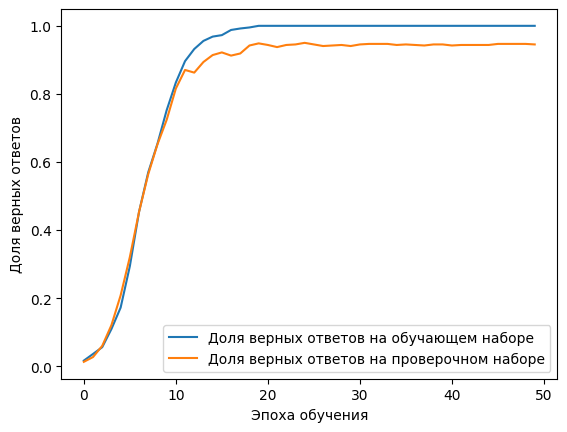

In [16]:
# Визуализация точности на обучающей выборке
plt.plot(history_small.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')

# Визуализация точности на проверочной выборке
plt.plot(history_small.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')

# Отрисовка подписей осей
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')

# Отрисовка легенды
plt.legend()

# Вывод графика
plt.show()

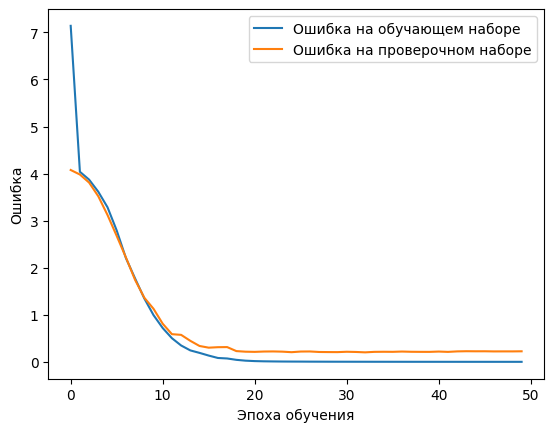

In [17]:
# Визуализация точности на обучающей выборке
plt.plot(history_small.history['loss'], 
         label='Ошибка на обучающем наборе')

# Визуализация точности на проверочной выборке
plt.plot(history_small.history['val_loss'], 
         label='Ошибка на проверочном наборе')

# Отрисовка подписей осей
plt.xlabel('Эпоха обучения')
plt.ylabel('Ошибка')

plt.legend()

plt.show()

## **Проверка evaluate**

In [47]:
scores_small = model_1.evaluate(x_data_test, 
                                y_data_test, 
                                verbose=1
                                )

print('Процент верных ответов на тестовых данных размером 80 на 60:', round(scores_small[1],4) * 100, '%')

2/2 [==============================] - 0s 10ms/step - loss: 1.4798 - accuracy: 0.7812
Процент верных ответов на тестовых данных размером 80 на 60: 78.12 %


## **Проверка predict**

In [50]:
x = x_data_test[5]
print(x.shape)

x = np.expand_dims(x, axis=0)
print(x.shape)

prediction = model_1.predict(x) 
print(prediction)

pred = np.argmax(prediction)
print(f'Распознан пациент: {pred}')
print(f'Настоящий пациент: {np.argmax(y_data_test[5])}')

(60, 80, 3)
(1, 60, 80, 3)
1/1 [==============================] - 0s 19ms/step
[[3.1212225e-21 1.5747939e-12 1.4007269e-10 2.4936155e-21 3.8381325e-12
  9.9928916e-01 5.4711612e-17 5.5020407e-14 5.4334837e-21 2.4314807e-06
  1.6155625e-04 3.3270258e-14 7.8821870e-07 5.5931445e-21 3.0516567e-08
  6.1342576e-26 1.3943083e-10 7.7758641e-06 2.3362339e-14 2.0967153e-19
  3.0517509e-26 1.6068059e-17 1.8672142e-18 1.5887419e-15 8.6014997e-25
  2.2089310e-09 1.0013806e-07 3.2214337e-27 1.6266704e-06 2.9055574e-09
  7.7838259e-19 3.4924103e-18 4.7726536e-12 4.6481594e-29 3.7487494e-05
  7.5011622e-13 3.0392304e-09 6.3689448e-10 2.3672655e-21 2.2122237e-13
  7.4367221e-11 3.9531640e-18 2.2036102e-18 1.1055599e-22 4.2225528e-22
  3.9450500e-15 9.1476133e-09 3.3649648e-26 8.7455795e-05 6.3230624e-07
  1.7068388e-16 6.1345578e-05 2.4236949e-10 4.4323727e-09 8.7358650e-15
  8.6076426e-09 1.9663888e-16 6.9084223e-08 1.1691959e-13 1.8443088e-06
  1.8788609e-14 2.6428232e-19 3.4757485e-04 2.2366557e-11